In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
import seaborn as sns
import math
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import feature_selection
# Ignore sklearn warning for now
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
import os
os.getcwd()

'/mnt/3106DB277DCCEAA5/Sync/Research/Coding/medicine/gods21/experiments/paris'

In [3]:
gene_exp = pd.read_csv('../../../../Data/down_syndrome/paris/x.csv', index_col=0)
phenotypes = pd.read_csv('../../../../Data/down_syndrome/paris/y.csv', index_col=0)
gene_description = pd.read_csv('../../../../Data/down_syndrome/paris/genes.csv', index_col=0)
x = gene_exp
le = preprocessing.LabelEncoder()
le.fit(phenotypes['Expected_AD'])
y = le.transform(phenotypes['Expected_AD'])
le.classes_

array(['no', 'yes'], dtype=object)

In [4]:
pvalues = feature_selection.r_regression(x, y)#[1]
sort_select_idx = np.argsort(pvalues)[-20:][::-1]
pvalues_ss = pvalues[sort_select_idx]
genes_ss = gene_exp.columns[sort_select_idx]

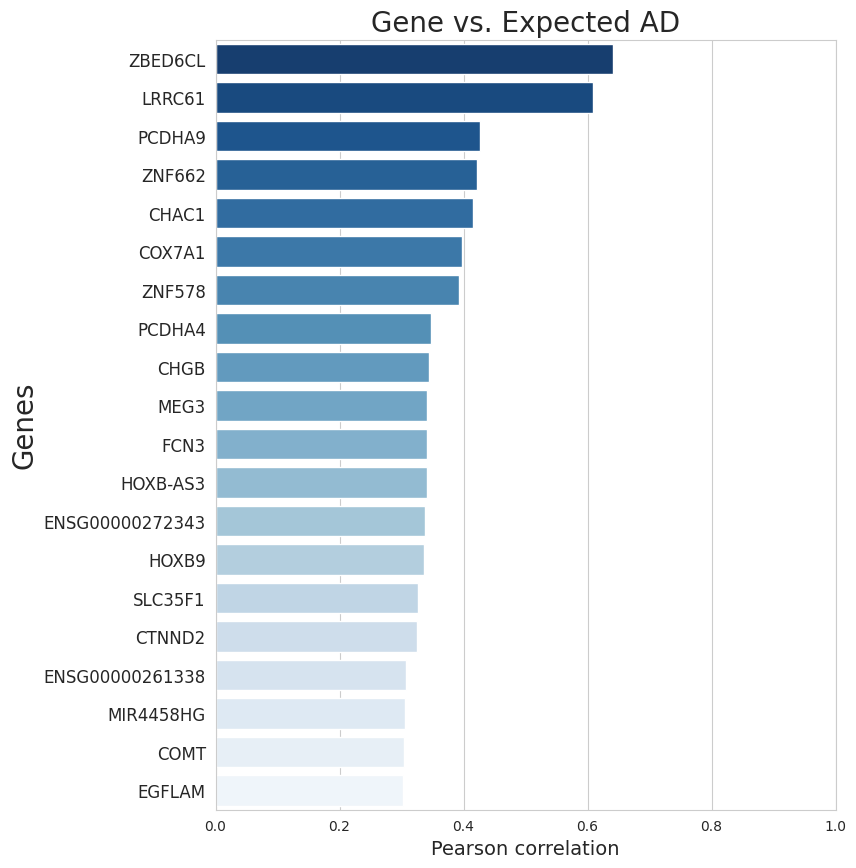

In [5]:
# norm = plt.Normalize(-1,1)
# sm = plt.cm.ScalarMappable(cmap="vlag", norm=norm)
# sm.set_array([])
plt.figure(figsize=[8, 10])
plt.title("Gene vs. Expected AD", fontsize=20)
sns.barplot(x=pvalues_ss, y=genes_ss, palette="Blues_r", orient="h")
plt.yticks(fontsize=12)
plt.xlabel("Pearson correlation", fontsize=14)
plt.ylabel('Genes', fontsize=20)
# plt.colorbar()
plt.xlim([0, 1])
plt.savefig('linear_correlations.png',dpi = 400, bbox_inches='tight')

In [6]:
for gene_name in genes_ss:
    print(gene_name, gene_description.loc[gene_name].values)

ZBED6CL ['ZBED6 C-terminal like [Source:HGNC Symbol;Acc:HGNC:21720]']
LRRC61 ['leucine rich repeat containing 61 [Source:HGNC Symbol;Acc:HGNC:21704]']
PCDHA9 ['protocadherin alpha 9 [Source:HGNC Symbol;Acc:HGNC:8675]']
ZNF662 ['zinc finger protein 662 [Source:HGNC Symbol;Acc:HGNC:31930]']
CHAC1 ['ChaC glutathione specific gamma-glutamylcyclotransferase 1 [Source:HGNC Symbol;Acc:HGNC:28680]']
COX7A1 ['cytochrome c oxidase subunit 7A1 [Source:HGNC Symbol;Acc:HGNC:2287]']
ZNF578 ['zinc finger protein 578 [Source:HGNC Symbol;Acc:HGNC:26449]']
PCDHA4 ['protocadherin alpha 4 [Source:HGNC Symbol;Acc:HGNC:8670]']
CHGB ['chromogranin B [Source:HGNC Symbol;Acc:HGNC:1930]']
MEG3 ['maternally expressed 3 [Source:HGNC Symbol;Acc:HGNC:14575]']
FCN3 ['ficolin 3 [Source:HGNC Symbol;Acc:HGNC:3625]']
HOXB-AS3 ['HOXB cluster antisense RNA 3 [Source:HGNC Symbol;Acc:HGNC:40283]']
ENSG00000272343 ['novel transcript']
HOXB9 ['homeobox B9 [Source:HGNC Symbol;Acc:HGNC:5120]']
SLC35F1 ['solute carrier family 35

In [10]:
x = x.values

In [11]:
accuracy = []
feature_importance = []
skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(x, y)):
    bst = XGBClassifier()
    scaler = StandardScaler()
    
    scaler.fit(x[train_index])
    x = scaler.transform(x)
    
    bst.fit(x[train_index], y[train_index])
    y_pred = bst.predict(x[test_index])
    
    acc = accuracy_score(y[test_index], y_pred)
    print(acc)
    accuracy.append(acc)
    feature_importance.append(bst.feature_importances_ / np.max(bst.feature_importances_))
    
feature_importance = np.stack(feature_importance).T

0.5625
0.8125
0.9375
0.8125
0.6


In [12]:
print(f'Accuracy: {np.mean(accuracy):.2f} +- {np.std(accuracy):.2f}')

Accuracy: 0.74 +- 0.14


In [13]:
feature_importance_mean = np.mean(feature_importance, axis=1)
sort_select_idx = np.argsort(feature_importance_mean)[-20:][::-1]
pvalues_ss = feature_importance_mean[sort_select_idx]
genes_ss = gene_exp.columns[sort_select_idx]
genes_ss

Index(['ZBED6CL', 'LRRC61', 'MTMR9LP', 'BTBD1', 'IDI1', 'SLC1A3', 'ME2',
       'EEF1E1', 'DCK', 'NDUFC2', 'SYPL1', 'SLC35G2', 'HEXB', 'HLA-DRB1',
       'CREG1', 'CADM4', 'EGFLAM', 'TM4SF1', 'ZMIZ2', 'ZNF578'],
      dtype='object')

In [14]:
results = pd.DataFrame(feature_importance[sort_select_idx], index=genes_ss).stack().reset_index()
results.columns = ['gene', 'split', 'relevance']
results

,gene,split,relevance
0,ZBED6CL,0,0.916706
1,ZBED6CL,1,0.726327
2,ZBED6CL,2,0.203275
3,ZBED6CL,3,0.296967
4,ZBED6CL,4,0.157406
...,...,...,...
95,ZNF578,0,0.000000
96,ZNF578,1,0.088315
97,ZNF578,2,0.140490
98,ZNF578,3,0.074491


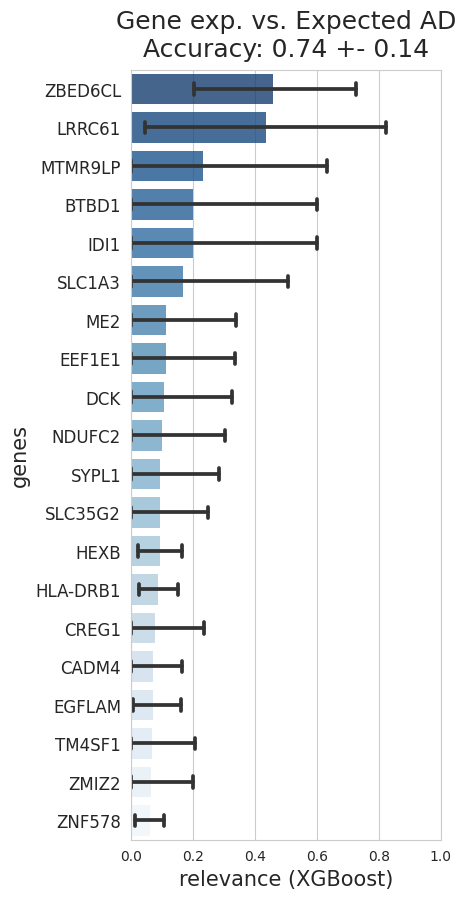

In [15]:
plt.figure(figsize=[4, 10])
plt.title(f"Gene exp. vs. Expected AD\nAccuracy: {np.mean(accuracy):.2f} +- {np.std(accuracy):.2f}", fontsize=18, pad=10)
sns.barplot(
    data=results, x="relevance", y="gene",
    errorbar=("ci", 95),
    capsize=.3, 
    errcolor="0.2",
    linewidth=0, 
    edgecolor=".5", 
#     facecolor=(0, 0, 0, 0),
    palette="Blues_r",
    alpha=0.8,
)
plt.yticks(fontsize=12)
plt.xlabel("relevance (XGBoost)", fontsize=15)
plt.ylabel('genes', fontsize=15)
plt.xlim([0, 1])
plt.savefig('xgboost_importance.png',dpi = 400, bbox_inches='tight')
plt.show()

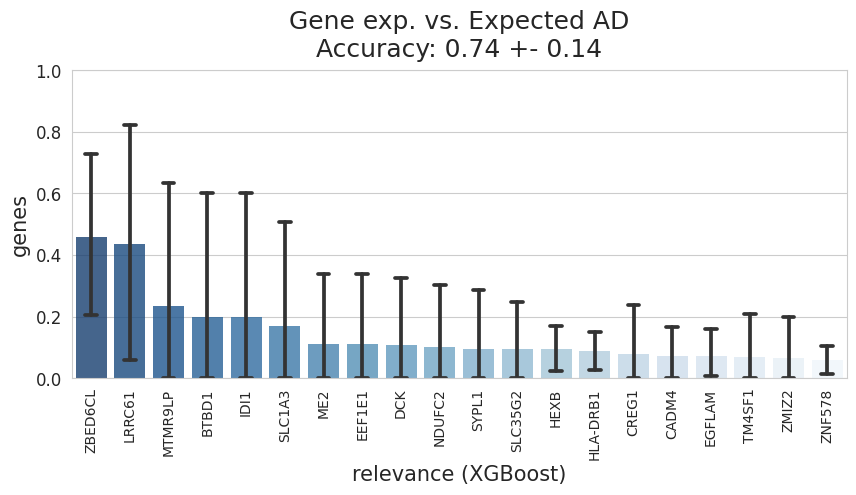

In [20]:
plt.figure(figsize=[10, 4])
plt.title(f"Gene exp. vs. Expected AD\nAccuracy: {np.mean(accuracy):.2f} +- {np.std(accuracy):.2f}", fontsize=18, pad=10)
sns.barplot(
    data=results, y="relevance", x="gene",
    errorbar=("ci", 95),
    capsize=.3, 
    errcolor="0.2",
    linewidth=0, 
    edgecolor=".5", 
#     facecolor=(0, 0, 0, 0),
    palette="Blues_r",
    alpha=0.8,
)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.xlabel("relevance (XGBoost)", fontsize=15)
plt.ylabel('genes', fontsize=15)
plt.ylim([0, 1])
plt.savefig('xgboost_importance.png',dpi = 400, bbox_inches='tight')
plt.show()

In [ ]:
for gene_name in genes_ss:
    print(gene_name, gene_description.loc[gene_name].values)